In [1]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa


def compute_radon_features(microbleed_rois, angles):
    sinograms = []
    for roi_slice in microbleed_rois:
        rotated_slices = [scipy.ndimage.rotate(roi_slice, angle, reshape=False) for angle in angles]
        sinogram = np.stack(rotated_slices, axis=-1)
        sinograms.append(sinogram)
    return np.stack(sinograms, axis=0)

def compute_radon_shape_features(radon_features):
    # Extract the dimensions
    num_coordinates, roi_size_x, roi_size_y, roi_size_z, num_angles = radon_features.shape
    
    # Initialize arrays to store results
    fmean = np.zeros((num_coordinates, num_angles))
    fstd = np.zeros((num_coordinates, num_angles))
    
    # Compute Radon shape features
    for coord in range(num_coordinates):
        for angle in range(num_angles):
            # Mean profile
            fmean[coord, angle] = np.mean(radon_features[coord, :, :, :, angle])
            
            # Standard deviation profile
            fstd[coord, angle] = np.std(radon_features[coord, :, :, :, angle])

            
    return fmean, fstd

# Load the Excel file containing microbleed coordinates
excel_file = 'sCMB_yes-train.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'sCMB/training'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10 # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Radon features for each ROI
        angles = np.arange(0, 180, 15)
        radon_features_microbleed = compute_radon_features(microbleed_rois, angles)

        # Compute Radon shape features for each microbleed
        fmean_microbleed_radon, fstd_microbleed_radon = compute_radon_shape_features(radon_features_microbleed)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue

            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append(np.array([f_sphere, f_lc, f_fa]))

        # Append Radon features (flattened) with Hessian features 
        for coord, fmean_values, fstd_values, hessian_features in zip(
                microbleed_coordinates, fmean_microbleed_radon, fstd_microbleed_radon, hessian_shape_features_microbleed
        ):
            flattened_radon_values = np.concatenate((fmean_values.flatten(), fstd_values.flatten()))
            combined_features = np.concatenate((np.array(flattened_radon_values), np.array(hessian_features)))
            #print(hessian_features)
            #print(flattened_radon_values)
            #print(combined_features)
            X.append(combined_features)
            #print(X)
          
            #print()
# Convert the list of microbleed features to a NumPy array
X1 =  np.array(X)
print(X1.shape)
print(X1)

(6990, 27)
[[4.56199807e+02 3.63989296e+02 3.44962648e+02 ... 7.98997722e+00
  2.18719866e+01 1.20166194e+00]
 [4.69896670e+02 3.75837841e+02 3.56992875e+02 ... 1.81285238e+00
  5.83076776e-01 1.22226505e+00]
 [4.63255970e+02 3.72685818e+02 3.54117458e+02 ... 2.21284135e+00
  9.81130044e-01 1.07289427e+00]
 ...
 [4.64101409e+02 3.72611158e+02 3.53560866e+02 ... 3.76407998e+00
  1.59706275e-01 1.21735348e+00]
 [4.80508501e+02 3.83845591e+02 3.64544166e+02 ... 2.00264355e+00
  7.94846709e-01 1.11396615e+00]
 [4.38511974e+02 3.49925556e+02 3.32444885e+02 ... 1.35204245e+00
  5.93352127e-01 1.19895928e+00]]


In [6]:
import nibabel as nib
import numpy as np
import pandas as pd
from skimage.transform import radon
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import SimpleITK as sitk
import os

# Step 1: Load annotations from Excel files
def load_annotations(excel_file, folder_path, label):
    """Load annotations from an Excel file with multiple coordinate sets per row."""
    try:
        df = pd.read_excel(excel_file)
    except Exception as e:
        print(f"Error loading {excel_file}: {e}")
        return {}
    
    print(f"Columns in {excel_file}: {list(df.columns)}")
    
    if 'NIFTI' not in df.columns:
        print(f"Error: 'NIFTI' column not found in {excel_file}")
        return {}
    
    annotations = {}
    # Identify coordinate columns (e.g., 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3')
    coord_columns = [col for col in df.columns if col.startswith('Location CMB #')]
    coord_groups = []
    
    for loc_col in coord_columns:
        # Get index of the 'Location CMB # N' column
        loc_idx = df.columns.get_loc(loc_col)
        # Assume next two columns are y, z (Unnamed)
        if loc_idx + 2 < len(df.columns):
            coord_groups.append((loc_col, df.columns[loc_idx + 1], df.columns[loc_idx + 2]))
    
    if not coord_groups:
        print(f"Error: No coordinate groups found in {excel_file}")
        return {}
    
    for _, row in df.iterrows():
        nifti_file = row['NIFTI']
        subject_id = os.path.splitext(nifti_file)[0]  # Strip .nii/.nii.gz
        if subject_id not in annotations:
            annotations[subject_id] = []
        
        # Extract coordinates from each group
        for x_col, y_col, z_col in coord_groups:
            try:
                x, y, z = row[x_col], row[y_col], row[z_col]
                if any(pd.isna(c) or not isinstance(c, (int, float)) for c in [x, y, z]):
                    continue  # Skip if coordinates are missing or invalid
                annotations[subject_id].append({'coord': (x, y, z), 'label': label})
            except Exception as e:
                print(f"Error processing coordinates for {nifti_file} in {excel_file}: {e}")
                continue
    
    print(f"Loaded {sum(len(v) for v in annotations.values())} annotations from {excel_file} with label {label}")
    return annotations

# Step 2: Load NIfTI files
def load_nifti_files(folder_path):
    """Load all NIfTI files from the specified folder."""
    nifti_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                   if f.endswith('.nii') or f.endswith('.nii.gz')]
    if not nifti_files:
        print(f"No NIfTI files found in {folder_path}")
        return [], [], []
    
    images = []
    affines = []
    for f in nifti_files:
        try:
            img = nib.load(f)
            images.append(img.get_fdata())
            affines.append(img.affine)
        except Exception as e:
            print(f"Error loading {f}: {e}")
    
    print(f"Loaded {len(images)} NIfTI files from {folder_path}")
    return images, nifti_files, affines

# Step 3: Preprocess SWI images
def preprocess_swi(image):
    """Apply bias field correction and intensity normalization."""
    try:
        sitk_image = sitk.GetImageFromArray(image)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected_image = corrector.Execute(sitk_image)
        corrected_array = sitk.GetArrayFromImage(corrected_image)
        
        corrected_array = np.clip(corrected_array, 0, np.percentile(corrected_array, 99))
        normalized_array = (corrected_array - corrected_array.min()) / (corrected_array.max() - corrected_array.min())
        inverted_array = 1 - normalized_array
        return inverted_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

# Step 4: Feature Extraction
def extract_features(image, coordinates, patch_size=(24, 24, 20), sigma=2.0):
    """Extract Radon and Hessian-based features for each coordinate."""
    features = []
    
    for coord in coordinates:
        x, y, z = coord
        if not (0 <= x < image.shape[2] and 0 <= y < image.shape[1] and 0 <= z < image.shape[0]):
            print(f"Skipping out-of-bounds coordinate: ({x}, {y}, {z})")
            continue
        
        z0, z1 = max(0, int(z - patch_size[0] // 2)), min(image.shape[0], int(z + patch_size[0] // 2))
        y0, y1 = max(0, int(y - patch_size[1] // 2)), min(image.shape[1], int(y + patch_size[1] // 2))
        x0, x1 = max(0, int(x - patch_size[2] // 2)), min(image.shape[2], int(x + patch_size[2] // 2))
        patch = image[z0:z1, y0:y1, x0:x1]
        
        if patch.shape != patch_size:
            patch = np.pad(patch, [(0, max(0, patch_size[0] - patch.shape[0])),
                                   (0, max(0, patch_size[1] - patch.shape[1])),
                                   (0, max(0, patch_size[2] - patch.shape[2]))],
                           mode='constant', constant_values=0)
            patch = patch[:patch_size[0], :patch_size[1], :patch_size[2]]
        
        theta = np.linspace(0, 180, max(patch.shape), endpoint=False)
        radon_img = radon(patch.sum(axis=0), theta=theta, circle=False)
        radon_features = radon_img.flatten()[:50]
        
        try:
            H = hessian_matrix(patch, sigma=sigma, order='rc')
            eigvals = hessian_matrix_eigvals(H)
            eigvals = [e.flatten() for e in eigvals]
            lambda1, lambda2, lambda3 = sorted([np.abs(e.mean()) for e in eigvals])
            
            f_sphere = lambda1 / np.sqrt(lambda2 * lambda3) if lambda2 * lambda3 > 0 else 0
            f_lc = lambda2 / lambda3 if lambda3 > 0 else 0
            f_fa = np.sqrt(0.5 * ((lambda1 - lambda2)**2 + (lambda2 - lambda3)**2 + (lambda1 - lambda3)**2) /
                           (lambda1**2 + lambda2**2 + lambda3**2 + 1e-10))
            
            candidate_features = np.concatenate([radon_features, [f_sphere, f_lc, f_fa]])
            features.append(candidate_features)
        except Exception as e:
            print(f"Error computing features for coordinate ({x}, {y}, {z}): {e}")
            continue
    
    return np.array(features) if features else np.empty((0, 53))

# Step 5: Classification
def train_classifier(features, labels):
    """Train a Random Forest classifier."""
    if len(features) == 0 or len(labels) == 0:
        print("No features or labels to train classifier")
        return None
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf

# Main function
def main():
    microbleed_excel = 'sCmb_filteredV5_output-small.xlsx'
    non_microbleed_excel = 'scmb_filteredV6_output-small.xlsx'
    folder_path = 'chunk'
    
    annotations = {
        **load_annotations(microbleed_excel, folder_path, label=1),
        **load_annotations(non_microbleed_excel, folder_path, label=0)
    }
    if not annotations:
        print("No annotations loaded. Exiting.")
        return
    
    images, nifti_files, affines = load_nifti_files(folder_path)
    if not images:
        print("No images loaded. Exiting.")
        return
    
    all_features = []
    all_labels = []
    
    for img_idx, (image, nifti_file, affine) in enumerate(zip(images, nifti_files, affines)):
        subject_id = os.path.splitext(os.path.basename(nifti_file))[0]
        print(f"Processing {nifti_file} (subject_id: {subject_id})")
        
        processed_img = preprocess_swi(image)
        if processed_img is None:
            continue
        
        if subject_id in annotations:
            subject_annotations = annotations[subject_id]
            coordinates = [ann['coord'] for ann in subject_annotations]
            labels = [ann['label'] for ann in subject_annotations]
            
            # Optional: Transform coordinates from physical to voxel space
            # coordinates = np.linalg.inv(affine) @ np.hstack([np.array(coordinates), 
            #                                                  np.ones((len(coordinates), 1))]).T[:3].T
            
            features = extract_features(processed_img, coordinates)
            if features.shape[0] > 0:
                all_features.append(features)
                all_labels.append(labels)
        else:
            print(f"No annotations for subject {subject_id}")
    
    if all_features:
        all_features = np.vstack(all_features)
        all_labels = np.concatenate(all_labels)
        print(f"Total features extracted: {all_features.shape[0]}")
        
        clf = train_classifier(all_features, all_labels)
        
        np.save('detected_features.npy', all_features)
        np.save('detected_labels.npy', all_labels)
    else:
        print("No features extracted. Exiting.")

if __name__ == "__main__":
    main()

Columns in sCmb_filteredV5_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12', 'Location CMB # 5', 'Unnamed: 14', 'Unnamed: 15', 'Location CMB # 6', 'Unnamed: 17', 'Unnamed: 18', 'Location CMB # 7', 'Unnamed: 20', 'Unnamed: 21', 'Location CMB # 8', 'Unnamed: 23', 'Unnamed: 24', 'Location CMB # 9', 'Unnamed: 26', 'Unnamed: 27', 'Location CMB # 10', 'Unnamed: 29', 'Unnamed: 30']
Loaded 20 annotations from sCmb_filteredV5_output-small.xlsx with label 1
Columns in scmb_filteredV6_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12', 'Location CMB # 5', 'Unnamed: 14', 'Unnamed: 15', 'Location CMB # 6', 'Unnamed: 17', 'Unnamed: 18', 'Location CMB # 7', 'Unna

C:\Users\Dell\AppData\Local\Temp\ipykernel_15772\649845307.py:130: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H = hessian_matrix(patch, sigma=sigma, order='rc')


Skipping out-of-bounds coordinate: (109, 130, 37)
Skipping out-of-bounds coordinate: (97, 121, 38)
Skipping out-of-bounds coordinate: (111, 128, 34)
Skipping out-of-bounds coordinate: (113, 206, 24)
Skipping out-of-bounds coordinate: (137, 114, 46)
Skipping out-of-bounds coordinate: (99, 109, 61)
Total features extracted: 10


ValueError: Found input variables with inconsistent numbers of samples: [10, 20]

In [28]:

# Determine the number of microbleeds in X
num_microbleeds = X1.shape[0]

# Set the labels for microbleeds as 1
Y1 = np.ones(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y1.shape}")

# Display a few labels to confirm
print(Y1)

Shape of Y0 (labels): (6990,)
[1. 1. 1. ... 1. 1. 1.]


In [29]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa


def compute_radon_features(microbleed_rois, angles):
    sinograms = []
    for roi_slice in microbleed_rois:
        rotated_slices = [scipy.ndimage.rotate(roi_slice, angle, reshape=False) for angle in angles]
        sinogram = np.stack(rotated_slices, axis=-1)
        sinograms.append(sinogram)
    return np.stack(sinograms, axis=0)

def compute_radon_shape_features(radon_features):
    # Extract the dimensions
    num_coordinates, roi_size_x, roi_size_y, roi_size_z, num_angles = radon_features.shape
    
    # Initialize arrays to store results
    fmean = np.zeros((num_coordinates, num_angles))
    fstd = np.zeros((num_coordinates, num_angles))
    
    # Compute Radon shape features
    for coord in range(num_coordinates):
        for angle in range(num_angles):
            # Mean profile
            fmean[coord, angle] = np.mean(radon_features[coord, :, :, :, angle])
            
            # Standard deviation profile
            fstd[coord, angle] = np.std(radon_features[coord, :, :, :, angle])

            
    return fmean, fstd

# Load the Excel file containing microbleed coordinates
excel_file = 'sCMB_yes.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'sCMB/testing'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10 # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Radon features for each ROI
        angles = np.arange(0, 180, 15)
        radon_features_microbleed = compute_radon_features(microbleed_rois, angles)

        # Compute Radon shape features for each microbleed
        fmean_microbleed_radon, fstd_microbleed_radon = compute_radon_shape_features(radon_features_microbleed)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue

            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append(np.array([f_sphere, f_lc, f_fa]))

        # Append Radon features (flattened) with Hessian features 
        for coord, fmean_values, fstd_values, hessian_features in zip(
                microbleed_coordinates, fmean_microbleed_radon, fstd_microbleed_radon, hessian_shape_features_microbleed
        ):
            flattened_radon_values = np.concatenate((fmean_values.flatten(), fstd_values.flatten()))
            combined_features = np.concatenate((np.array(flattened_radon_values), np.array(hessian_features)))
            #print(hessian_features)
            #print(flattened_radon_values)
            #print(combined_features)
            X.append(combined_features)
            #print(X)
          
            #print()
# Convert the list of microbleed features to a NumPy array
X2 =  np.array(X)
print(X2.shape)
print(X2)

(2190, 27)
[[4.65325734e+02 3.74136784e+02 3.56643892e+02 ... 6.82822768e-01
  1.74740651e+00 1.07259455e+00]
 [4.81606204e+02 3.84437011e+02 3.64973628e+02 ... 5.54332603e+00
  1.47477690e+01 1.21538121e+00]
 [4.25154268e+02 3.41425938e+02 3.25499691e+02 ... 7.70316867e+00
  4.97667827e-01 1.11725423e+00]
 ...
 [4.49624850e+02 3.61396572e+02 3.44370595e+02 ... 1.38574796e+00
  1.52202277e-01 1.16526015e+00]
 [4.99768827e+02 4.02264502e+02 3.83193674e+02 ... 4.56270331e+00
  5.78713294e-01 7.39794019e-01]
 [5.05158043e+02 4.04592366e+02 3.84689690e+02 ... 6.45260834e+00
  3.30133884e-01 1.14444748e+00]]


In [30]:

# Determine the number of microbleeds in X
num_microbleeds = X2.shape[0]

# Set the labels for microbleeds as 1
Y2 = np.ones(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y2.shape}")

# Display a few labels to confirm
print(Y2)

Shape of Y0 (labels): (2190,)
[1. 1. 1. ... 1. 1. 1.]


In [8]:
import nibabel as nib
import numpy as np
import pandas as pd
from skimage.transform import radon
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import SimpleITK as sitk
import os

# Step 1: Load annotations from Excel files
def load_annotations(excel_file, folder_path, label):
    """Load annotations from an Excel file with multiple coordinate sets per row."""
    try:
        df = pd.read_excel(excel_file)
    except Exception as e:
        print(f"Error loading {excel_file}: {e}")
        return {}
    
    print(f"Columns in {excel_file}: {list(df.columns)}")
    
    if 'NIFTI' not in df.columns:
        print(f"Error: 'NIFTI' column not found in {excel_file}")
        return {}
    
    annotations = {}
    # Handle both 'Location CMB #' and 'Location non-CMB #' for flexibility
    coord_columns = [col for col in df.columns if col.startswith('Location CMB #') or col.startswith('Location non-CMB #')]
    coord_groups = []
    
    for loc_col in coord_columns:
        loc_idx = df.columns.get_loc(loc_col)
        if loc_idx + 2 < len(df.columns):
            coord_groups.append((loc_col, df.columns[loc_idx + 1], df.columns[loc_idx + 2]))
    
    if not coord_groups:
        print(f"Error: No coordinate groups found in {excel_file}")
        return {}
    
    for _, row in df.iterrows():
        nifti_file = row['NIFTI']
        # Strip .nii or .nii.gz to get subject_id
        subject_id = os.path.splitext(os.path.splitext(nifti_file)[0])[0]
        if subject_id not in annotations:
            annotations[subject_id] = []
        
        for x_col, y_col, z_col in coord_groups:
            try:
                x, y, z = row[x_col], row[y_col], row[z_col]
                if any(pd.isna(c) or not isinstance(c, (int, float)) for c in [x, y, z]):
                    continue
                annotations[subject_id].append({'coord': (x, y, z), 'label': label})
            except Exception as e:
                print(f"Error processing coordinates for {nifti_file} in {excel_file}: {e}")
                continue
    
    print(f"Loaded {sum(len(v) for v in annotations.values())} annotations from {excel_file} with label {label}")
    return annotations

# Step 2: Load NIfTI files
def load_nifti_files(folder_path):
    """Load all NIfTI files from the specified folder."""
    nifti_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                   if f.endswith('.nii') or f.endswith('.nii.gz')]
    if not nifti_files:
        print(f"No NIfTI files found in {folder_path}")
        return [], [], []
    
    images = []
    affines = []
    for f in nifti_files:
        try:
            img = nib.load(f)
            images.append(img.get_fdata())
            affines.append(img.affine)
        except Exception as e:
            print(f"Error loading {f}: {e}")
    
    print(f"Loaded {len(images)} NIfTI files from {folder_path}")
    return images, nifti_files, affines

# Step 3: Preprocess SWI images
def preprocess_swi(image):
    """Apply bias field correction and intensity normalization."""
    try:
        sitk_image = sitk.GetImageFromArray(image)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected_image = corrector.Execute(sitk_image)
        corrected_array = sitk.GetArrayFromImage(corrected_image)
        
        corrected_array = np.clip(corrected_array, 0, np.percentile(corrected_array, 99))
        normalized_array = (corrected_array - corrected_array.min()) / (corrected_array.max() - corrected_array.min())
        inverted_array = 1 - normalized_array
        return inverted_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

# Step 4: Feature Extraction
def extract_features(image, coordinates, labels, patch_size=(24, 24, 20), sigma=2.0):
    """Extract Radon and Hessian-based features for each coordinate."""
    features = []
    valid_labels = []
    
    for coord, label in zip(coordinates, labels):
        x, y, z = coord
        if not (0 <= x < image.shape[2] and 0 <= y < image.shape[1] and 0 <= z < image.shape[0]):
            print(f"Skipping out-of-bounds coordinate: ({x}, {y}, {z})")
            continue
        
        z0, z1 = max(0, int(z - patch_size[0] // 2)), min(image.shape[0], int(z + patch_size[0] // 2))
        y0, y1 = max(0, int(y - patch_size[1] // 2)), min(image.shape[1], int(y + patch_size[1] // 2))
        x0, x1 = max(0, int(x - patch_size[2] // 2)), min(image.shape[2], int(x + patch_size[2] // 2))
        patch = image[z0:z1, y0:y1, x0:x1]
        
        if patch.shape != patch_size:
            patch = np.pad(patch, [(0, max(0, patch_size[0] - patch.shape[0])),
                                   (0, max(0, patch_size[1] - patch.shape[1])),
                                   (0, max(0, patch_size[2] - patch.shape[2]))],
                           mode='constant', constant_values=0)
            patch = patch[:patch_size[0], :patch_size[1], :patch_size[2]]
        
        theta = np.linspace(0, 180, max(patch.shape), endpoint=False)
        radon_img = radon(patch.sum(axis=0), theta=theta, circle=False)
        radon_features = radon_img.flatten()[:50]
        
        try:
            H = hessian_matrix(patch, sigma=sigma, order='rc', use_gaussian_derivatives=False)
            eigvals = hessian_matrix_eigvals(H)
            eigvals = [e.flatten() for e in eigvals]
            lambda1, lambda2, lambda3 = sorted([np.abs(e.mean()) for e in eigvals])
            
            f_sphere = lambda1 / np.sqrt(lambda2 * lambda3) if lambda2 * lambda3 > 0 else 0
            f_lc = lambda2 / lambda3 if lambda3 > 0 else 0
            f_fa = np.sqrt(0.5 * ((lambda1 - lambda2)**2 + (lambda2 - lambda3)**2 + (lambda1 - lambda3)**2) /
                           (lambda1**2 + lambda2**2 + lambda3**2 + 1e-10))
            
            candidate_features = np.concatenate([radon_features, [f_sphere, f_lc, f_fa]])
            features.append(candidate_features)
            valid_labels.append(label)
        except Exception as e:
            print(f"Error computing features for coordinate ({x}, {y}, {z}): {e}")
            continue
    
    return np.array(features) if features else np.empty((0, 53)), valid_labels

# Step 5: Classification
def train_classifier(features, labels):
    """Train a Random Forest classifier."""
    if len(features) == 0 or len(labels) == 0:
        print("No features or labels to train classifier")
        return None
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf

# Main function
def main():
    microbleed_excel = 'sCmb_filteredV5_output-small.xlsx'
    non_microbleed_excel = 'scmb_filteredV6_output-small.xlsx'
    folder_path = 'chunk'
    
    annotations = {
        **load_annotations(microbleed_excel, folder_path, label=1),
        **load_annotations(non_microbleed_excel, folder_path, label=0)
    }
    if not annotations:
        print("No annotations loaded. Exiting.")
        return
    
    images, nifti_files, affines = load_nifti_files(folder_path)
    if not images:
        print("No images loaded. Exiting.")
        return
    
    all_features = []
    all_labels = []
    
    for img_idx, (image, nifti_file, affine) in enumerate(zip(images, nifti_files, affines)):
        subject_id = os.path.splitext(os.path.basename(nifti_file))[0]
        print(f"Processing {nifti_file} (subject_id: {subject_id})")
        print(f"Image dimensions: {image.shape}")
        
        processed_img = preprocess_swi(image)
        if processed_img is None:
            continue
        
        if subject_id in annotations:
            subject_annotations = annotations[subject_id]
            coordinates = [ann['coord'] for ann in subject_annotations]
            labels = [ann['label'] for ann in subject_annotations]
            print(f"Coordinates for {subject_id}: {coordinates}")
            
            features, valid_labels = extract_features(processed_img, coordinates, labels)
            if features.shape[0] > 0:
                all_features.append(features)
                all_labels.append(valid_labels)
        else:
            print(f"No annotations for subject {subject_id}")
    
    if all_features:
        all_features = np.vstack(all_features)
        all_labels = np.concatenate(all_labels)
        print(f"Total features extracted: {all_features.shape[0]}")
        print(f"Total labels: {len(all_labels)}")
        
        clf = train_classifier(all_features, all_labels)
        
        np.save('detected_features.npy', all_features)
        np.save('detected_labels.npy', all_labels)
    else:
        print("No features extracted. Exiting.")

if __name__ == "__main__":
    main()

Columns in sCmb_filteredV5_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12', 'Location CMB # 5', 'Unnamed: 14', 'Unnamed: 15', 'Location CMB # 6', 'Unnamed: 17', 'Unnamed: 18', 'Location CMB # 7', 'Unnamed: 20', 'Unnamed: 21', 'Location CMB # 8', 'Unnamed: 23', 'Unnamed: 24', 'Location CMB # 9', 'Unnamed: 26', 'Unnamed: 27', 'Location CMB # 10', 'Unnamed: 29', 'Unnamed: 30']
Loaded 20 annotations from sCmb_filteredV5_output-small.xlsx with label 1
Columns in scmb_filteredV6_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12', 'Location CMB # 5', 'Unnamed: 14', 'Unnamed: 15', 'Location CMB # 6', 'Unnamed: 17', 'Unnamed: 18', 'Location CMB # 7', 'Unna

In [9]:
import nibabel as nib
import numpy as np
import pandas as pd
from skimage.transform import radon
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import SimpleITK as sitk
import os

# Step 1: Load annotations from Excel files
def load_annotations(excel_file, folder_path, label):
    """Load annotations from an Excel file with multiple coordinate sets per row."""
    try:
        df = pd.read_excel(excel_file)
    except Exception as e:
        print(f"Error loading {excel_file}: {e}")
        return {}
    
    print(f"Columns in {excel_file}: {list(df.columns)}")
    
    if 'NIFTI' not in df.columns:
        print(f"Error: 'NIFTI' column not found in {excel_file}")
        return {}
    
    annotations = {}
    coord_columns = [col for col in df.columns if col.startswith('Location CMB #') or col.startswith('Location non-CMB #')]
    coord_groups = []
    
    for loc_col in coord_columns:
        loc_idx = df.columns.get_loc(loc_col)
        if loc_idx + 2 < len(df.columns):
            coord_groups.append((loc_col, df.columns[loc_idx + 1], df.columns[loc_idx + 2]))
    
    if not coord_groups:
        print(f"Error: No coordinate groups found in {excel_file}")
        return {}
    
    subject_ids = []
    for _, row in df.iterrows():
        nifti_file = row['NIFTI']
        # Strip .nii or .nii.gz to get subject_id
        subject_id = nifti_file
        if subject_id.endswith('.nii.gz'):
            subject_id = subject_id[:-7]
        elif subject_id.endswith('.nii'):
            subject_id = subject_id[:-4]
        subject_ids.append(subject_id)
        if subject_id not in annotations:
            annotations[subject_id] = []
        
        for x_col, y_col, z_col in coord_groups:
            try:
                x, y, z = row[x_col], row[y_col], row[z_col]
                if any(pd.isna(c) or not isinstance(c, (int, float)) for c in [x, y, z]):
                    continue
                annotations[subject_id].append({'coord': (x, y, z), 'label': label})
            except Exception as e:
                print(f"Error processing coordinates for {nifti_file} in {excel_file}: {e}")
                continue
    
    print(f"Subject IDs in {excel_file}: {subject_ids}")
    print(f"Loaded {sum(len(v) for v in annotations.values())} annotations from {excel_file} with label {label}")
    return annotations

# Step 2: Load NIfTI files
def load_nifti_files(folder_path):
    """Load all NIfTI files from the specified folder."""
    nifti_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                   if f.endswith('.nii') or f.endswith('.nii.gz')]
    if not nifti_files:
        print(f"No NIfTI files found in {folder_path}")
        return [], [], []
    
    images = []
    affines = []
    for f in nifti_files:
        try:
            img = nib.load(f)
            images.append(img.get_fdata())
            affines.append(img.affine)
        except Exception as e:
            print(f"Error loading {f}: {e}")
    
    print(f"Loaded {len(images)} NIfTI files from {folder_path}")
    return images, nifti_files, affines

# Step 3: Preprocess SWI images
def preprocess_swi(image):
    """Apply bias field correction and intensity normalization."""
    try:
        sitk_image = sitk.GetImageFromArray(image)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        corrected_image = corrector.Execute(sitk_image)
        corrected_array = sitk.GetArrayFromImage(corrected_image)
        
        corrected_array = np.clip(corrected_array, 0, np.percentile(corrected_array, 99))
        normalized_array = (corrected_array - corrected_array.min()) / (corrected_array.max() - corrected_array.min())
        inverted_array = 1 - normalized_array
        return inverted_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

# Step 4: Feature Extraction
def extract_features(image, coordinates, labels, patch_size=(24, 24, 20), sigma=2.0):
    """Extract Radon and Hessian-based features for each coordinate."""
    features = []
    valid_labels = []
    
    for coord, label in zip(coordinates, labels):
        x, y, z = coord
        if not (0 <= x < image.shape[2] and 0 <= y < image.shape[1] and 0 <= z < image.shape[0]):
            print(f"Skipping out-of-bounds coordinate: ({x}, {y}, {z})")
            continue
        
        z0, z1 = max(0, int(z - patch_size[0] // 2)), min(image.shape[0], int(z + patch_size[0] // 2))
        y0, y1 = max(0, int(y - patch_size[1] // 2)), min(image.shape[1], int(y + patch_size[1] // 2))
        x0, x1 = max(0, int(x - patch_size[2] // 2)), min(image.shape[2], int(x + patch_size[2] // 2))
        patch = image[z0:z1, y0:y1, x0:x1]
        
        if patch.shape != patch_size:
            patch = np.pad(patch, [(0, max(0, patch_size[0] - patch.shape[0])),
                                   (0, max(0, patch_size[1] - patch.shape[1])),
                                   (0, max(0, patch_size[2] - patch.shape[2]))],
                           mode='constant', constant_values=0)
            patch = patch[:patch_size[0], :patch_size[1], :patch_size[2]]
        
        theta = np.linspace(0, 180, max(patch.shape), endpoint=False)
        radon_img = radon(patch.sum(axis=0), theta=theta, circle=False)
        radon_features = radon_img.flatten()[:50]
        
        try:
            H = hessian_matrix(patch, sigma=sigma, order='rc', use_gaussian_derivatives=False)
            eigvals = hessian_matrix_eigvals(H)
            eigvals = [e.flatten() for e in eigvals]
            lambda1, lambda2, lambda3 = sorted([np.abs(e.mean()) for e in eigvals])
            
            f_sphere = lambda1 / np.sqrt(lambda2 * lambda3) if lambda2 * lambda3 > 0 else 0
            f_lc = lambda2 / lambda3 if lambda3 > 0 else 0
            f_fa = np.sqrt(0.5 * ((lambda1 - lambda2)**2 + (lambda2 - lambda3)**2 + (lambda1 - lambda3)**2) /
                           (lambda1**2 + lambda2**2 + lambda3**2 + 1e-10))
            
            candidate_features = np.concatenate([radon_features, [f_sphere, f_lc, f_fa]])
            features.append(candidate_features)
            valid_labels.append(label)
        except Exception as e:
            print(f"Error computing features for coordinate ({x}, {y}, {z}): {e}")
            continue
    
    return np.array(features) if features else np.empty((0, 53)), valid_labels

# Step 5: Classification
def train_classifier(features, labels):
    """Train a Random Forest classifier."""
    if len(features) == 0 or len(labels) == 0:
        print("No features or labels to train classifier")
        return None
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf

# Main function
def main():
    microbleed_excel = 'sCmb_filteredV5_output-small.xlsx'
    non_microbleed_excel = 'scmb_filteredV6_output-small.xlsx'
    folder_path = 'chunk'
    
    annotations = {
        **load_annotations(microbleed_excel, folder_path, label=1),
        **load_annotations(non_microbleed_excel, folder_path, label=0)
    }
    if not annotations:
        print("No annotations loaded. Exiting.")
        return
    
    images, nifti_files, affines = load_nifti_files(folder_path)
    if not images:
        print("No images loaded. Exiting.")
        return
    
    all_features = []
    all_labels = []
    
    for img_idx, (image, nifti_file, affine) in enumerate(zip(images, nifti_files, affines)):
        subject_id = os.path.splitext(os.path.basename(nifti_file))[0]
        print(f"Processing {nifti_file} (subject_id: {subject_id})")
        print(f"Image dimensions: {image.shape}")
        
        processed_img = preprocess_swi(image)
        if processed_img is None:
            continue
        
        if subject_id in annotations:
            subject_annotations = annotations[subject_id]
            coordinates = [ann['coord'] for ann in subject_annotations]
            labels = [ann['label'] for ann in subject_annotations]
            print(f"Coordinates for {subject_id}: {coordinates}")
            
            features, valid_labels = extract_features(processed_img, coordinates, labels)
            if features.shape[0] > 0:
                all_features.append(features)
                all_labels.append(valid_labels)
        else:
            print(f"No annotations for subject {subject_id}")
    
    if all_features:
        all_features = np.vstack(all_features)
        all_labels = np.concatenate(all_labels)
        print(f"Total features extracted: {all_features.shape[0]}")
        print(f"Total labels: {len(all_labels)}")
        
        clf = train_classifier(all_features, all_labels)
        
        np.save('detected_features.npy', all_features)
        np.save('detected_labels.npy', all_labels)
    else:
        print("No features extracted. Exiting.")

if __name__ == "__main__":
    main()

Columns in sCmb_filteredV5_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12', 'Location CMB # 5', 'Unnamed: 14', 'Unnamed: 15', 'Location CMB # 6', 'Unnamed: 17', 'Unnamed: 18', 'Location CMB # 7', 'Unnamed: 20', 'Unnamed: 21', 'Location CMB # 8', 'Unnamed: 23', 'Unnamed: 24', 'Location CMB # 9', 'Unnamed: 26', 'Unnamed: 27', 'Location CMB # 10', 'Unnamed: 29', 'Unnamed: 30']
Subject IDs in sCmb_filteredV5_output-small.xlsx: ['101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1', '102_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1']
Loaded 20 annotations from sCmb_filteredV5_output-small.xlsx with label 1
Columns in scmb_filteredV6_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12'

In [14]:
import nibabel as nib
import numpy as np
import pandas as pd
from skimage.transform import radon
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os

# Step 1: Load annotations from Excel files
def load_annotations(excel_file, folder_path, label):
    """Load annotations from an Excel file with multiple coordinate sets per row."""
    try:
        df = pd.read_excel(excel_file)
    except Exception as e:
        print(f"Error loading {excel_file}: {e}")
        return {}
    
    print(f"Columns in {excel_file}: {list(df.columns)}")
    
    if 'NIFTI' not in df.columns:
        print(f"Error: 'NIFTI' column not found in {excel_file}")
        return {}
    
    annotations = {}
    coord_columns = [col for col in df.columns if col.startswith('Location CMB #') or col.startswith('Location non-CMB #')]
    coord_groups = []
    
    for loc_col in coord_columns:
        loc_idx = df.columns.get_loc(loc_col)
        if loc_idx + 2 < len(df.columns):
            coord_groups.append((loc_col, df.columns[loc_idx + 1], df.columns[loc_idx + 2]))
    
    if not coord_groups:
        print(f"Error: No coordinate groups found in {excel_file}")
        return {}
    
    subject_ids = []
    for _, row in df.iterrows():
        nifti_file = row['NIFTI']
        # Strip .nii or .nii.gz to get subject_id
        subject_id = nifti_file
        if subject_id.endswith('.nii.gz'):
            subject_id = subject_id[:-7]
        elif subject_id.endswith('.nii'):
            subject_id = subject_id[:-4]
        subject_ids.append(subject_id)
        if subject_id not in annotations:
            annotations[subject_id] = []
        
        coord_count = 0
        for x_col, y_col, z_col in coord_groups:
            try:
                x, y, z = row[x_col], row[y_col], row[z_col]
                if any(pd.isna(c) or not isinstance(c, (int, float)) for c in [x, y, z]):
                    continue
                annotations[subject_id].append({'coord': (x, y, z), 'label': label})
                coord_count += 1
            except Exception as e:
                print(f"Error processing coordinates for {nifti_file} in {excel_file}: {e}")
                continue
        print(f"Loaded {coord_count} coordinates for {subject_id} in {excel_file}")
    
    print(f"Subject IDs in {excel_file}: {subject_ids}")
    print(f"Total annotations loaded from {excel_file} with label {label}: {sum(len(v) for v in annotations.values())}")
    return annotations

# Step 2: Load NIfTI files
def load_nifti_files(folder_path):
    """Load all NIfTI files from the specified folder."""
    nifti_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                   if f.endswith('.nii') or f.endswith('.nii.gz')]
    if not nifti_files:
        print(f"No NIfTI files found in {folder_path}")
        return [], [], []
    
    images = []
    affines = []
    for f in nifti_files:
        try:
            img = nib.load(f)
            images.append(img.get_fdata())
            affines.append(img.affine)
        except Exception as e:
            print(f"Error loading {f}: {e}")
    
    print(f"Loaded {len(images)} NIfTI files from {folder_path}")
    return images, nifti_files, affines

# Step 3: Feature Extraction
def extract_features(image, coordinates, labels, subject_id, patch_size=(24, 24, 20), sigma=2.0):
    """Extract Radon and Hessian-based features for each coordinate."""
    features = []
    valid_labels = []
    
    for coord, label in zip(coordinates, labels):
        z, y, x = coord  # Swap x and z to match image dimensions (z, y, x)
        print(f"Processing coordinate for {subject_id} (original: {coord}, interpreted as z,y,x: ({z}, {y}, {x}), label: {label})")
        if not (0 <= x < image.shape[2] and 0 <= y < image.shape[1] and 0 <= z < image.shape[0]):
            print(f"Skipping out-of-bounds coordinate: ({x}, {y}, {z})")
            continue
        
        z0, z1 = max(0, int(z - patch_size[0] // 2)), min(image.shape[0], int(z + patch_size[0] // 2))
        y0, y1 = max(0, int(y - patch_size[1] // 2)), min(image.shape[1], int(y + patch_size[1] // 2))
        x0, x1 = max(0, int(x - patch_size[2] // 2)), min(image.shape[2], int(x + patch_size[2] // 2))
        patch = image[z0:z1, y0:y1, x0:x1]
        
        if patch.shape != patch_size:
            patch = np.pad(patch, [(0, max(0, patch_size[0] - patch.shape[0])),
                                   (0, max(0, patch_size[1] - patch.shape[1])),
                                   (0, max(0, patch_size[2] - patch.shape[2]))],
                           mode='constant', constant_values=0)
            patch = patch[:patch_size[0], :patch_size[1], :patch_size[2]]
        
        theta = np.linspace(0, 180, max(patch.shape), endpoint=False)
        radon_img = radon(patch.sum(axis=0), theta=theta, circle=False)
        radon_features = radon_img.flatten()[:50]
        
        try:
            H = hessian_matrix(patch, sigma=sigma, order='rc', use_gaussian_derivatives=False)
            eigvals = hessian_matrix_eigvals(H)
            eigvals = [e.flatten() for e in eigvals]
            lambda1, lambda2, lambda3 = sorted([np.abs(e.mean()) for e in eigvals])
            
            f_sphere = lambda1 / np.sqrt(lambda2 * lambda3) if lambda2 * lambda3 > 0 else 0
            f_lc = lambda2 / lambda3 if lambda3 > 0 else 0
            f_fa = np.sqrt(0.5 * ((lambda1 - lambda2)**2 + (lambda2 - lambda3)**2 + (lambda1 - lambda3)**2) /
                           (lambda1**2 + lambda2**2 + lambda3**2 + 1e-10))
            
            candidate_features = np.concatenate([radon_features, [f_sphere, f_lc, f_fa]])
            print(f"Features for {subject_id}, coordinate ({z}, {y}, {x}), label {label}: {candidate_features}")
            features.append(candidate_features)
            valid_labels.append(label)
        except Exception as e:
            print(f"Error computing features for coordinate ({x}, {y}, {z}) in {subject_id}: {e}")
            continue
    
    return np.array(features) if features else np.empty((0, 53)), valid_labels

# Step 4: Classification
def train_classifier(features, labels):
    """Train a Random Forest classifier."""
    if len(features) == 0 or len(labels) == 0:
        print("No features or labels to train classifier")
        return None
    
    # Print label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Label distribution: {dict(zip(unique, counts))}")
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf

# Main function
def main():
    microbleed_excel = 'sCmb_filteredV5_output-small.xlsx'
    non_microbleed_excel = 'scmb_filteredV6_output-small.xlsx'
    folder_path = 'chunk'
    
    annotations = {
        **load_annotations(microbleed_excel, folder_path, label=1),
        **load_annotations(non_microbleed_excel, folder_path, label=0)
    }
    if not annotations:
        print("No annotations loaded. Exiting.")
        return
    
    images, nifti_files, affines = load_nifti_files(folder_path)
    if not images:
        print("No images loaded. Exiting.")
        return
    
    all_features = []
    all_labels = []
    
    for img_idx, (image, nifti_file, affine) in enumerate(zip(images, nifti_files, affines)):
        subject_id = os.path.basename(nifti_file)
        if subject_id.endswith('.nii.gz'):
            subject_id = subject_id[:-7]
        elif subject_id.endswith('.nii'):
            subject_id = subject_id[:-4]
        print(f"Processing {nifti_file} (subject_id: {subject_id})")
        print(f"Image dimensions: {image.shape}")
        
        if subject_id in annotations:
            subject_annotations = annotations[subject_id]
            coordinates = [ann['coord'] for ann in subject_annotations]
            labels = [ann['label'] for ann in subject_annotations]
            print(f"Coordinates for {subject_id}: {coordinates}")
            
            features, valid_labels = extract_features(image, coordinates, labels, subject_id)
            if features.shape[0] > 0:
                all_features.append(features)
                all_labels.append(valid_labels)
        else:
            print(f"No annotations for subject {subject_id}")
    
    if all_features:
        all_features = np.vstack(all_features)
        print(f"All features: {all_features}")
        all_labels = np.concatenate(all_labels)
        print(f"Total features extracted: {all_features.shape[0]}")
        print(f"Total labels: {len(all_labels)}")
        
        clf = train_classifier(all_features, all_labels)
        
        np.save('detected_features.npy', all_features)
        np.save('detected_labels.npy', all_labels)
    else:
        print("No features extracted. Exiting.")

if __name__ == "__main__":
    main()

Columns in sCmb_filteredV5_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12', 'Location CMB # 5', 'Unnamed: 14', 'Unnamed: 15', 'Location CMB # 6', 'Unnamed: 17', 'Unnamed: 18', 'Location CMB # 7', 'Unnamed: 20', 'Unnamed: 21', 'Location CMB # 8', 'Unnamed: 23', 'Unnamed: 24', 'Location CMB # 9', 'Unnamed: 26', 'Unnamed: 27', 'Location CMB # 10', 'Unnamed: 29', 'Unnamed: 30']
Loaded 10 coordinates for 101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1 in sCmb_filteredV5_output-small.xlsx
Loaded 10 coordinates for 102_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1 in sCmb_filteredV5_output-small.xlsx
Subject IDs in sCmb_filteredV5_output-small.xlsx: ['101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1', '102_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1']
Total annotations loaded from sCmb_filteredV5_output-small.xlsx with label 1: 20
Columns in scmb_filteredV6_output-small.xlsx:

In [18]:
import nibabel as nib
import numpy as np
import pandas as pd
from skimage.transform import radon
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt

# Step 1: Load annotations from Excel files
def load_annotations(excel_file, folder_path, label):
    """Load annotations from an Excel file with multiple coordinate sets per row."""
    try:
        df = pd.read_excel(excel_file)
    except Exception as e:
        print(f"Error loading {excel_file}: {e}")
        return {}
    
    print(f"Columns in {excel_file}: {list(df.columns)}")
    
    if 'NIFTI' not in df.columns:
        print(f"Error: 'NIFTI' column not found in {excel_file}")
        return {}
    
    annotations = {}
    coord_columns = [col for col in df.columns if col.startswith('Location CMB #')]
    coord_groups = []
    
    for loc_col in coord_columns:
        loc_idx = df.columns.get_loc(loc_col)
        if loc_idx + 2 < len(df.columns):
            coord_groups.append((loc_col, df.columns[loc_idx + 1], df.columns[loc_idx + 2]))
    
    if not coord_groups:
        print(f"Error: No coordinate groups found in {excel_file}")
        return {}
    
    subject_ids = []
    for _, row in df.iterrows():
        nifti_file = row['NIFTI']
        subject_id = nifti_file
        if subject_id.endswith('.nii.gz'):
            subject_id = subject_id[:-7]
        elif subject_id.endswith('.nii'):
            subject_id = subject_id[:-4]
        subject_ids.append(subject_id)
        if subject_id not in annotations:
            annotations[subject_id] = []
        
        coord_count = 0
        for x_col, y_col, z_col in coord_groups:
            try:
                x, y, z = row[x_col], row[y_col], row[z_col]
                if any(pd.isna(c) or not isinstance(c, (int, float)) for c in [x, y, z]):
                    print(f"Skipping invalid coordinate ({x}, {y}, {z}) for {nifti_file} in {excel_file}")
                    continue
                annotations[subject_id].append({'coord': (x, y, z), 'label': label})
                coord_count += 1
            except Exception as e:
                print(f"Error processing coordinates for {nifti_file} in {excel_file}: {e}")
                continue
        print(f"Loaded {coord_count} coordinates for {subject_id} in {excel_file}")
    
    print(f"Subject IDs in {excel_file}: {subject_ids}")
    print(f"Total annotations loaded from {excel_file} with label {label}: {sum(len(v) for v in annotations.values())}")
    
    nifti_files = [os.path.basename(f) for f in os.listdir(folder_path) if f.endswith(('.nii', '.nii.gz'))]
    nifti_ids = [f[:-7] if f.endswith('.nii.gz') else f[:-4] for f in nifti_files]
    unmatched_ids = [sid for sid in subject_ids if sid not in nifti_ids]
    if unmatched_ids:
        print(f"Warning: Subject IDs in {excel_file} not found in NIfTI files: {unmatched_ids}")
    
    return annotations

# Step 2: Load NIfTI files
def load_nifti_files(folder_path):
    """Load all NIfTI files from the specified folder."""
    nifti_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                   if f.endswith('.nii') or f.endswith('.nii.gz')]
    if not nifti_files:
        print(f"No NIfTI files found in {folder_path}")
        return [], [], []
    
    images = []
    affines = []
    for f in nifti_files:
        try:
            img = nib.load(f)
            images.append(img.get_fdata())
            affines.append(img.affine)
        except Exception as e:
            print(f"Error loading {f}: {e}")
    
    print(f"Loaded {len(images)} NIfTI files from {folder_path}")
    return images, nifti_files, affines

# Step 3: Feature Extraction
def extract_features(image, coordinates, labels, subject_id, patch_size=(12, 12, 10), sigma=2.0):
    """Extract Radon and Hessian-based features for each coordinate."""
    image = (image - image.min()) / (image.max() - image.min() + 1e-10)
    
    features = []
    valid_labels = []
    z_coords, y_coords, x_coords = [], [], []
    
    for coord, label in zip(coordinates, labels):
        x, y, z = coord
        z, y, x = z, y, x
        z = min(max(0, int(z)), image.shape[0] - 1)
        y = min(max(0, int(y)), image.shape[1] - 1)
        x = min(max(0, int(x)), image.shape[2] - 1)
        z_coords.append(z)
        y_coords.append(y)
        x_coords.append(x)
        print(f"Processing coordinate for {subject_id} (original x,y,z: ({coord[0]}, {coord[1]}, {coord[2]}), image z,y,x: ({z}, {y}, {x}), label: {label})")
        
        z0, z1 = max(0, int(z - patch_size[0] // 2)), min(image.shape[0], int(z + patch_size[0] // 2))
        y0, y1 = max(0, int(y - patch_size[1] // 2)), min(image.shape[1], int(y + patch_size[1] // 2))
        x0, x1 = max(0, int(x - patch_size[2] // 2)), min(image.shape[2], int(x + patch_size[2] // 2))
        patch = image[z0:z1, y0:y1, x0:x1]
        
        if patch.shape != patch_size:
            patch = np.pad(patch, [(0, max(0, patch_size[0] - patch.shape[0])),
                                   (0, max(0, patch_size[1] - patch.shape[1])),
                                   (0, max(0, patch_size[2] - patch.shape[2]))],
                           mode='constant', constant_values=0)
            patch = patch[:patch_size[0], :patch_size[1], :patch_size[2]]
        
        print(f"Patch intensity stats for {subject_id}, coordinate ({z}, {y}, {x}): min={patch.min()}, max={patch.max()}, mean={patch.mean()}")
        
        # Compute Radon features for multiple projections
        radon_features = []
        theta = np.linspace(0, 180, 100, endpoint=False)  # Increase resolution
        
        for axis, axis_name in [(0, 'z'), (1, 'y'), (2, 'x')]:
            patch_sum = patch.sum(axis=axis)
            # Scale patch_sum to enhance contrast
            patch_sum = (patch_sum - patch_sum.min()) / (patch_sum.max() - patch_sum.min() + 1e-10)
            print(f"Patch sum stats for {subject_id}, coordinate ({z}, {y}, {x}), axis={axis_name}: min={patch_sum.min()}, max={patch_sum.max()}, mean={patch_sum.mean()}")
            
            # Debug: Save patch_sum as image
            plt.imsave(f'patch_sum_{subject_id}_{z}_{y}_{x}_axis{axis_name}.png', patch_sum, cmap='gray')
            
            radon_img = radon(patch_sum, theta=theta, circle=False)
            print(f"Radon image stats for {subject_id}, coordinate ({z}, {y}, {x}), axis={axis_name}: min={radon_img.min()}, max={radon_img.max()}, mean={radon_img.mean()}")
            
            # Take first 50 features per projection
            radon_features_axis = radon_img.flatten()[:50]
            radon_features.extend(radon_features_axis)
        
        # Pad or truncate to ensure consistent feature length (150 for 3 axes)
        if len(radon_features) < 150:
            radon_features = np.pad(radon_features, (0, 150 - len(radon_features)), mode='constant', constant_values=0)
        else:
            radon_features = radon_features[:150]
        
        try:
            H = hessian_matrix(patch, sigma=sigma, order='rc', use_gaussian_derivatives=False)
            eigvals = hessian_matrix_eigvals(H)
            eigvals = [e.flatten() for e in eigvals]
            lambda1, lambda2, lambda3 = sorted([np.abs(e.mean()) for e in eigvals])
            
            f_sphere = lambda1 / np.sqrt(lambda2 * lambda3) if lambda2 * lambda3 > 0 else 0
            f_lc = lambda2 / lambda3 if lambda3 > 0 else 0
            f_fa = np.sqrt(0.5 * ((lambda1 - lambda2)**2 + (lambda2 - lambda3)**2 + (lambda1 - lambda3)**2) /
                           (lambda1**2 + lambda2**2 + lambda3**2 + 1e-10))
            
            candidate_features = np.concatenate([radon_features, [f_sphere, f_lc, f_fa]])
            print(f"Features for {subject_id}, coordinate ({z}, {y}, {x}), label {label}: {candidate_features}")
            features.append(candidate_features)
            valid_labels.append(label)
        except Exception as e:
            print(f"Error computing features for coordinate ({x}, {y}, {z}) in {subject_id}: {e}")
            continue
    
    if z_coords:
        print(f"Coordinate ranges for {subject_id}: z=[{min(z_coords)}, {max(z_coords)}], y=[{min(y_coords)}, {max(y_coords)}], x=[{min(x_coords)}, {max(x_coords)}]")
    
    return np.array(features) if features else np.empty((0, 153)), valid_labels

# Step 4: Classification
def train_classifier(features, labels):
    """Train a Random Forest classifier."""
    if len(features) == 0 or len(labels) == 0:
        print("No features or labels to train classifier")
        return None
    
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Label distribution: {dict(zip(unique, counts))}")
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf

# Main function
def main():
    microbleed_excel = 'sCmb_filteredV5_output-small.xlsx'
    non_microbleed_excel = 'scmb_filteredV6_output-small.xlsx'
    folder_path = 'chunk'
    
    microbleed_annotations = load_annotations(microbleed_excel, folder_path, label=1)
    non_microbleed_annotations = load_annotations(non_microbleed_excel, folder_path, label=0)
    
    annotations = {}
    for subject_id in set(list(microbleed_annotations.keys()) + list(non_microbleed_annotations.keys())):
        annotations[subject_id] = []
        if subject_id in microbleed_annotations:
            annotations[subject_id].extend(microbleed_annotations[subject_id])
        if subject_id in non_microbleed_annotations:
            annotations[subject_id].extend(non_microbleed_annotations[subject_id])
        print(f"Combined {len(annotations[subject_id])} annotations for {subject_id} (label counts: {np.unique([ann['label'] for ann in annotations[subject_id]], return_counts=True)})")
    
    if not annotations:
        print("No annotations loaded. Exiting.")
        return
    
    images, nifti_files, affines = load_nifti_files(folder_path)
    if not images:
        print("No images loaded. Exiting.")
        return
    
    all_features = []
    all_labels = []
    
    for img_idx, (image, nifti_file, affine) in enumerate(zip(images, nifti_files, affines)):
        subject_id = os.path.basename(nifti_file)
        if subject_id.endswith('.nii.gz'):
            subject_id = subject_id[:-7]
        elif subject_id.endswith('.nii'):
            subject_id = subject_id[:-4]
        print(f"Processing {nifti_file} (subject_id: {subject_id})")
        print(f"Image dimensions: {image.shape}")
        
        if subject_id in annotations:
            subject_annotations = annotations[subject_id]
            coordinates = [ann['coord'] for ann in subject_annotations]
            labels = [ann['label'] for ann in subject_annotations]
            print(f"Coordinates for {subject_id}: {coordinates}")
            print(f"Labels for {subject_id}: {labels}")
            
            features, valid_labels = extract_features(image, coordinates, labels, subject_id)
            if features.shape[0] > 0:
                all_features.append(features)
                all_labels.append(valid_labels)
        else:
            print(f"No annotations for subject {subject_id}")
    
    if all_features:
        all_features = np.vstack(all_features)
        print(f"All features: {all_features}")
        all_labels = np.concatenate(all_labels)
        print(f"Total features extracted: {all_features.shape[0]}")
        print(f"Total labels: {len(all_labels)}")
        
        clf = train_classifier(all_features, all_labels)
        
        np.save('detected_features.npy', all_features)
        np.save('detected_labels.npy', all_labels)
    else:
        print("No features extracted. Exiting.")

if __name__ == "__main__":
    main()

Columns in sCmb_filteredV5_output-small.xlsx: ['NIFTI', 'Location CMB # 1', 'Unnamed: 2', 'Unnamed: 3', 'Location CMB # 2', 'Unnamed: 5', 'Unnamed: 6', 'Location CMB # 3', 'Unnamed: 8', 'Unnamed: 9', 'Location CMB # 4', 'Unnamed: 11', 'Unnamed: 12', 'Location CMB # 5', 'Unnamed: 14', 'Unnamed: 15', 'Location CMB # 6', 'Unnamed: 17', 'Unnamed: 18', 'Location CMB # 7', 'Unnamed: 20', 'Unnamed: 21', 'Location CMB # 8', 'Unnamed: 23', 'Unnamed: 24', 'Location CMB # 9', 'Unnamed: 26', 'Unnamed: 27', 'Location CMB # 10', 'Unnamed: 29', 'Unnamed: 30']
Loaded 10 coordinates for 101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1 in sCmb_filteredV5_output-small.xlsx
Loaded 10 coordinates for 102_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1 in sCmb_filteredV5_output-small.xlsx
Subject IDs in sCmb_filteredV5_output-small.xlsx: ['101_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1', '102_T1_MRI_SWI_BFC_50mm_HM_sCMB_V1']
Total annotations loaded from sCmb_filteredV5_output-small.xlsx with label 1: 20
Columns in scmb_filteredV6_output-small.xlsx:

In [31]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa



def compute_radon_features(microbleed_rois, angles):
    sinograms = []
    for roi_slice in microbleed_rois:
        rotated_slices = [scipy.ndimage.rotate(roi_slice, angle, reshape=False) for angle in angles]
        sinogram = np.stack(rotated_slices, axis=-1)
        
        # Check if the current sinogram has the same shape as the previous sinograms
        if sinograms and sinogram.shape != sinograms[0].shape:
            #print("Skipping ROI due to different shape:", sinogram.shape)
            continue
        
        sinograms.append(sinogram)
        
    return np.stack(sinograms, axis=0)


def compute_radon_shape_features(radon_features):
    # Extract the dimensions
    num_coordinates, roi_size_x, roi_size_y, roi_size_z, num_angles = radon_features.shape
    
    # Initialize arrays to store results
    fmean = np.zeros((num_coordinates, num_angles))
    fstd = np.zeros((num_coordinates, num_angles))
    
    # Compute Radon shape features
    for coord in range(num_coordinates):
        for angle in range(num_angles):
            # Mean profile
            fmean[coord, angle] = np.mean(radon_features[coord, :, :, :, angle])
            
            # Standard deviation profile
            fstd[coord, angle] = np.std(radon_features[coord, :, :, :, angle])

            #print(fmean)
            #print(fstd)

            
    return fmean, fstd

# Load the Excel file containing microbleed coordinates
excel_file = 'sCmb_no-train.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'sCMB/training'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10  # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Radon features for each ROI
        angles = np.arange(0, 180, 15)
        radon_features_microbleed = compute_radon_features(microbleed_rois, angles)

        # Compute Radon shape features for each microbleed
        fmean_microbleed_radon, fstd_microbleed_radon = compute_radon_shape_features(radon_features_microbleed)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue

            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append(np.array([f_sphere, f_lc, f_fa]))

        # Append Radon features (flattened) with Hessian features 
        for coord, fmean_values, fstd_values, hessian_features in zip(
                microbleed_coordinates, fmean_microbleed_radon, fstd_microbleed_radon, hessian_shape_features_microbleed
):
            flattened_radon_values = np.concatenate((fmean_values.flatten(), fstd_values.flatten()))
            combined_features = np.concatenate((np.array(flattened_radon_values), np.array(hessian_features)))
            #print(hessian_features)
            #print(flattened_radon_values)
            #print(combined_features)
            X.append(combined_features)
            #print(X)
# Convert the list of microbleed features to a NumPy array
X01 =  np.array(X)
print(X01.shape)

(6990, 27)


In [32]:
# Assuming X contains the microbleed features

# Determine the number of microbleeds in X
num_microbleeds = X01.shape[0]

# Set the labels for microbleeds as 1
Y01 = np.zeros(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y01.shape}")

# Display a few labels to confirm
print(Y01) 

Shape of Y0 (labels): (6990,)
[0. 0. 0. ... 0. 0. 0.]


In [33]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa



def compute_radon_features(microbleed_rois, angles):
    sinograms = []
    for roi_slice in microbleed_rois:
        rotated_slices = [scipy.ndimage.rotate(roi_slice, angle, reshape=False) for angle in angles]
        sinogram = np.stack(rotated_slices, axis=-1)
        
        # Check if the current sinogram has the same shape as the previous sinograms
        if sinograms and sinogram.shape != sinograms[0].shape:
            #print("Skipping ROI due to different shape:", sinogram.shape)
            continue
        
        sinograms.append(sinogram)
        
    return np.stack(sinograms, axis=0)


def compute_radon_shape_features(radon_features):
    # Extract the dimensions
    num_coordinates, roi_size_x, roi_size_y, roi_size_z, num_angles = radon_features.shape
    
    # Initialize arrays to store results
    fmean = np.zeros((num_coordinates, num_angles))
    fstd = np.zeros((num_coordinates, num_angles))
    
    # Compute Radon shape features
    for coord in range(num_coordinates):
        for angle in range(num_angles):
            # Mean profile
            fmean[coord, angle] = np.mean(radon_features[coord, :, :, :, angle])
            
            # Standard deviation profile
            fstd[coord, angle] = np.std(radon_features[coord, :, :, :, angle])

            #print(fmean)
            #print(fstd)

            
    return fmean, fstd

# Load the Excel file containing microbleed coordinates
excel_file = 'sCmb_no-test.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'sCMB/testing'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10  # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Radon features for each ROI
        angles = np.arange(0, 180, 15)
        radon_features_microbleed = compute_radon_features(microbleed_rois, angles)

        # Compute Radon shape features for each microbleed
        fmean_microbleed_radon, fstd_microbleed_radon = compute_radon_shape_features(radon_features_microbleed)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue

            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append(np.array([f_sphere, f_lc, f_fa]))

        # Append Radon features (flattened) with Hessian features 
        for coord, fmean_values, fstd_values, hessian_features in zip(
                microbleed_coordinates, fmean_microbleed_radon, fstd_microbleed_radon, hessian_shape_features_microbleed
):
            flattened_radon_values = np.concatenate((fmean_values.flatten(), fstd_values.flatten()))
            combined_features = np.concatenate((np.array(flattened_radon_values), np.array(hessian_features)))
            #print(hessian_features)
            #print(flattened_radon_values)
            #print(combined_features)
            X.append(combined_features)
            #print(X)
# Convert the list of microbleed features to a NumPy array
X02 =  np.array(X)
print(X02.shape)

(2190, 27)


In [34]:
# Assuming X contains the microbleed features

# Determine the number of microbleeds in X
num_microbleeds = X02.shape[0]

# Set the labels for microbleeds as 1
Y02 = np.zeros(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y02.shape}")

# Display a few labels to confirm
print(Y02) 

Shape of Y0 (labels): (2190,)
[0. 0. 0. ... 0. 0. 0.]


In [35]:
X_train = np.vstack((X1, X01))
print(X_train.shape)

X_test = np.vstack((X2, X02))
print(X_test.shape)
# Create corresponding labels 'y' (1 for microbleeds, 0 for non-microbleeds)
y_train = np.hstack((Y1,Y01))
print(y_train.shape)

y_test = np.hstack((Y2,Y02))
print(y_test.shape)



(13980, 27)
(4380, 27)
(13980,)
(4380,)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import os

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict labels for the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Confusion matrix:
# [[TN, FP],
#  [FN, TP]]

TP = conf_matrix[1, 1]  # Correctly predicted class 1
FN = conf_matrix[1, 0]  # Predicted 0 but actually 1
FP = conf_matrix[0, 1]  # Predicted 1 but actually 0
TN = conf_matrix[0, 0]  # Correctly predicted class 0

# Sensitivity (Recall) for class 1
sensitivity_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

# Sensitivity (Recall) for class 0
sensitivity_0 = TN / (TN + FP) if (TN + FP) > 0 else 0

print("Sensitivity (Recall) for class 1 (microbleeds):", sensitivity_1)
print("Sensitivity (Recall) for class 0 (non-microbleeds):", sensitivity_0)

# Calculate False Positive Rate (FPR)
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FPR = TN / (TN + FP)
print("Specificity:", FPR)


# Save the model
with open('rf_classifier_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

(13980, 27)
(4380, 27)
(13980,)
(4380,)
Accuracy: 0.5029680365296804
Confusion Matrix:
[[1370  820]
 [1357  833]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.63      0.56      2190
         1.0       0.50      0.38      0.43      2190

    accuracy                           0.50      4380
   macro avg       0.50      0.50      0.50      4380
weighted avg       0.50      0.50      0.50      4380

Sensitivity (Recall) for class 1 (microbleeds): 0.38036529680365294
Sensitivity (Recall) for class 0 (non-microbleeds): 0.6255707762557078
Specificity: 0.6255707762557078


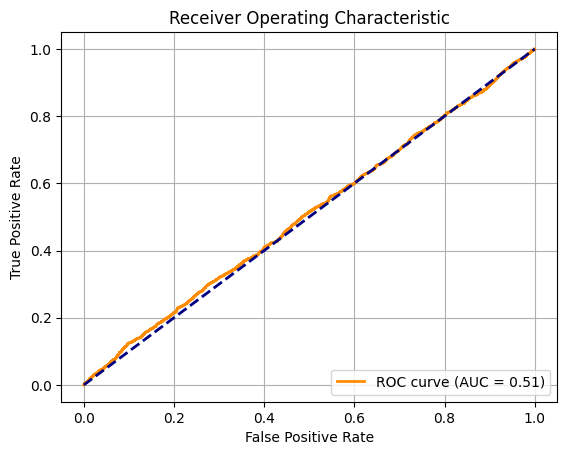

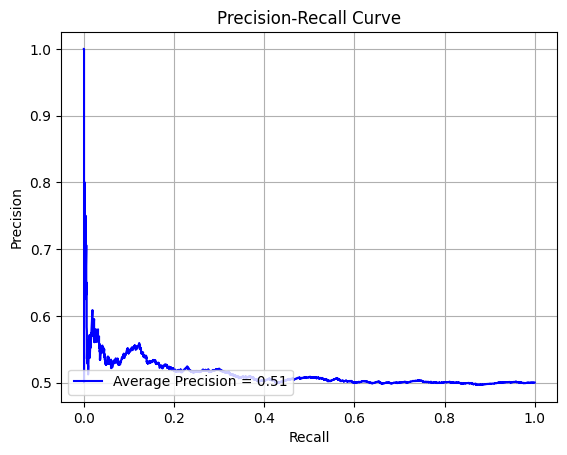

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_probs = rf_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()






In [38]:
(X_train, X_test, y_train, y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13980, 27)
(4380, 27)
(13980,)
(4380,)


Feature ranking:
1. feature 26 (0.091669)
2. feature 25 (0.077477)
3. feature 24 (0.069678)
4. feature 18 (0.045358)
5. feature 21 (0.041732)
6. feature 12 (0.037827)
7. feature 10 (0.037205)
8. feature 17 (0.035663)
9. feature 11 (0.034169)
10. feature 2 (0.033617)
11. feature 0 (0.033179)
12. feature 13 (0.032534)
13. feature 7 (0.032226)
14. feature 20 (0.032223)
15. feature 9 (0.032103)
16. feature 19 (0.031556)
17. feature 15 (0.031185)
18. feature 22 (0.030738)
19. feature 3 (0.030601)
20. feature 1 (0.028526)
21. feature 16 (0.028425)
22. feature 4 (0.027092)
23. feature 14 (0.026625)
24. feature 23 (0.026542)
25. feature 6 (0.026506)
26. feature 5 (0.025259)
27. feature 8 (0.020284)


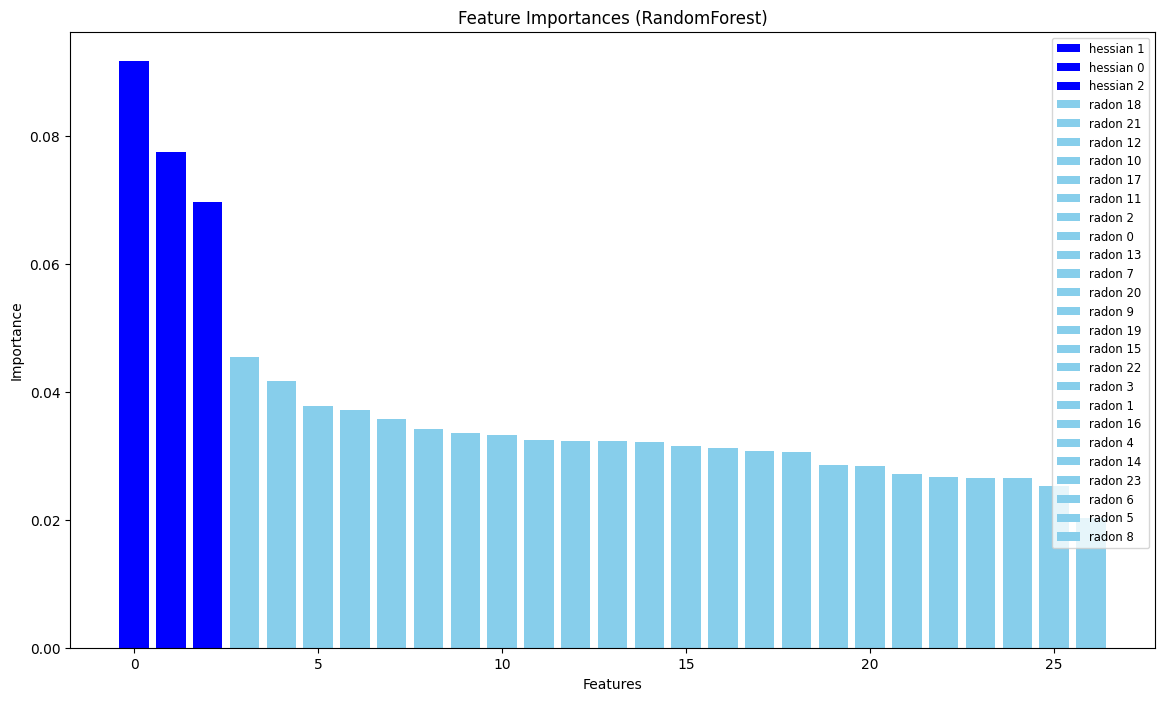

In [39]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train the RandomForest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_classifier.fit(X_train, y_train)

# Retrieve feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Define custom feature names for selected features
custom_feature_names = {
    25: 'hessian 0',
    26: 'hessian 1',
    24: 'hessian 2'
}

# Plot the feature importances 
plt.figure(figsize=(14, 8))  # Set the figure size to be larger
plt.title("Feature Importances (RandomForest)")

# Plot top 3 features with custom names, others with numerical indices
for i in range(X_train.shape[1]):
    color = "blue" if custom_feature_names.get(indices[i], None) else "skyblue"  # Set color based on feature name
    label = custom_feature_names.get(indices[i], f'radon {indices[i]}')
    plt.bar(i, importances[indices[i]], color=color, align="center", label=label)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.legend(fontsize='small')  # Set legend size to small
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import numpy as np
import pickle

# Assuming you have X and Y defined
# Split the data into training and testing sets
X_train, X_test, y_train, y_test

# Train the XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

# Predict labels for the testing set
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Calculate Sensitivity
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Calculate False Positive Rate (FPR)
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FPR = TN/ (TN + FP)
print("Specificity:", FPR)

# Save the model
with open('xgb_classifier_model.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)


Accuracy: 0.4858447488584475
Confusion Matrix:
[[1057 1133]
 [1119 1071]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.48      0.48      2190
         1.0       0.49      0.49      0.49      2190

    accuracy                           0.49      4380
   macro avg       0.49      0.49      0.49      4380
weighted avg       0.49      0.49      0.49      4380

Sensitivity: 0.48904109589041095
Specificity: 0.482648401826484


Accuracy: 0.4858447488584475
Confusion Matrix:
[[1057 1133]
 [1119 1071]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.48      0.48      2190
         1.0       0.49      0.49      0.49      2190

    accuracy                           0.49      4380
   macro avg       0.49      0.49      0.49      4380
weighted avg       0.49      0.49      0.49      4380

Sensitivity: 0.48904109589041095
Specificity: 0.482648401826484


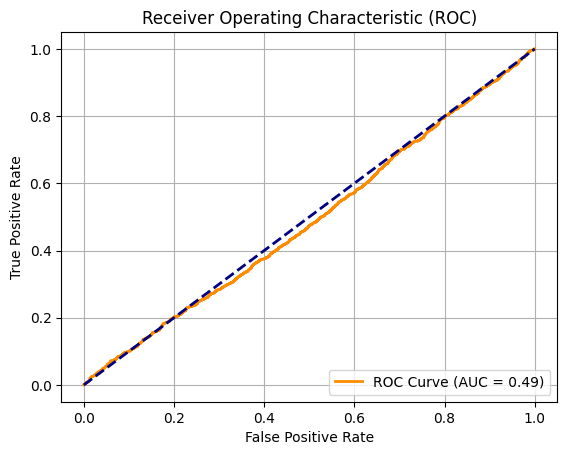

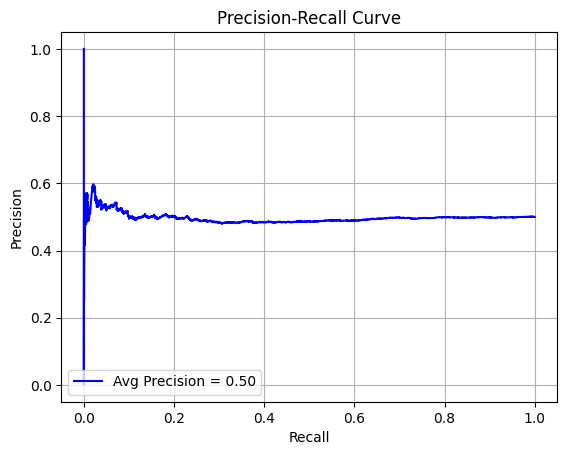

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Assuming X and Y are defined
X_train, X_test, y_train, y_test 

# Train the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train)

# Predict labels
y_pred = xgb_classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Sensitivity (Recall for class 1)
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
print("Sensitivity:", sensitivity)

# Specificity (True Negative Rate)
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
specificity = TN / (TN + FP)
print("Specificity:", specificity)

# ROC Curve + AUC
class_index = list(xgb_classifier.classes_).index(1)  # ensure correct class used
y_probs = xgb_classifier.predict_proba(X_test)[:, class_index]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Save model
with open('xgb_classifier_model.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)





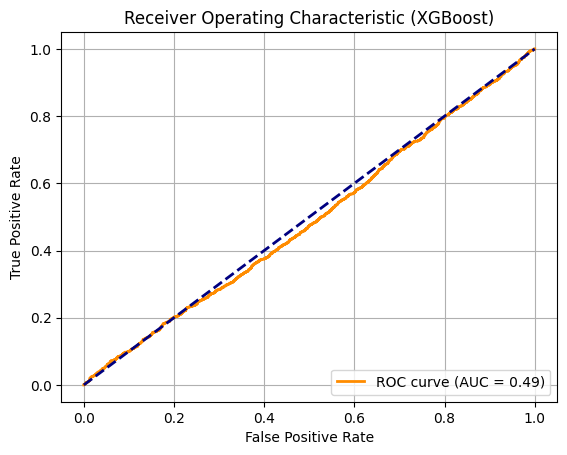

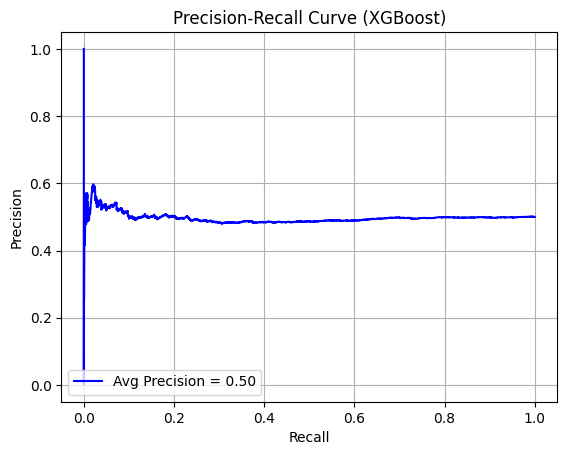

In [42]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get prediction probabilities for the positive class
y_probs = xgb_classifier.predict_proba(X_test)[:, 1]

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (XGBoost)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend(loc='lower left')
plt.grid()
plt.show()


Feature ranking:
1. feature 16 (0.076412)
2. feature 17 (0.076296)
3. feature 1 (0.071557)
4. feature 15 (0.071332)
5. feature 14 (0.069929)
6. feature 3 (0.069536)
7. feature 5 (0.067274)
8. feature 4 (0.065338)
9. feature 24 (0.063944)
10. feature 26 (0.063193)
11. feature 12 (0.063060)
12. feature 13 (0.062380)
13. feature 2 (0.061708)
14. feature 0 (0.059860)
15. feature 25 (0.058181)
16. feature 18 (0.000000)
17. feature 19 (0.000000)
18. feature 11 (0.000000)
19. feature 10 (0.000000)
20. feature 9 (0.000000)
21. feature 8 (0.000000)
22. feature 7 (0.000000)
23. feature 6 (0.000000)
24. feature 20 (0.000000)
25. feature 21 (0.000000)
26. feature 22 (0.000000)
27. feature 23 (0.000000)


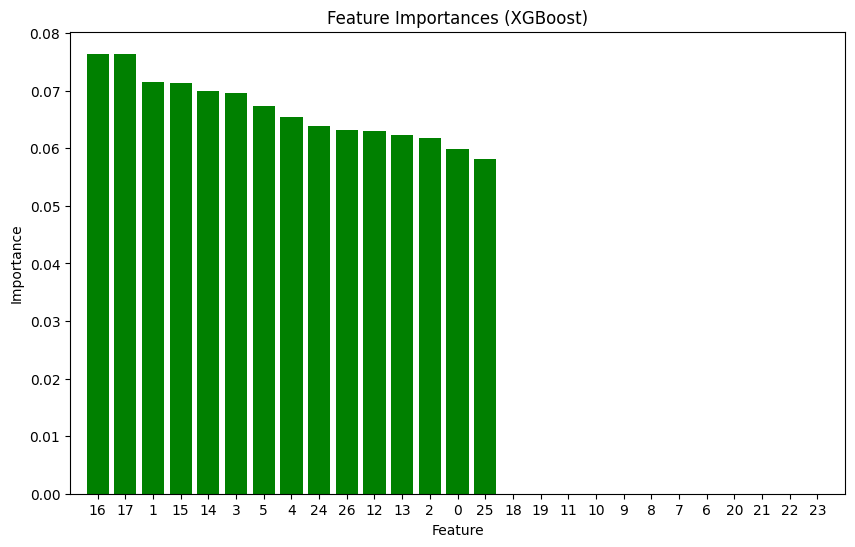

In [43]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Train the XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

# Retrieve feature importances
importances = xgb_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (XGBoost)")
plt.bar(range(X_train.shape[1]), importances[indices], color="g", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5283 - loss: 12.6951 - val_accuracy: 7.1531e-04 - val_loss: 4.1586
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5423 - loss: 1.7111 - val_accuracy: 0.0000e+00 - val_loss: 4.3664
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5337 - loss: 1.5415 - val_accuracy: 0.9986 - val_loss: 0.0147
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5418 - loss: 1.6189 - val_accuracy: 0.0000e+00 - val_loss: 3.3287
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5304 - loss: 1.1846 - val_accuracy: 0.0161 - val_loss: 0.9751
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5352 - loss: 8.1226 - val_accuracy: 0.0000e+00 - val_loss: 2.4887
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5362 - loss: 1.2161 - val_accuracy: 7.1531e-04 - val_loss: 1.2426
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5504

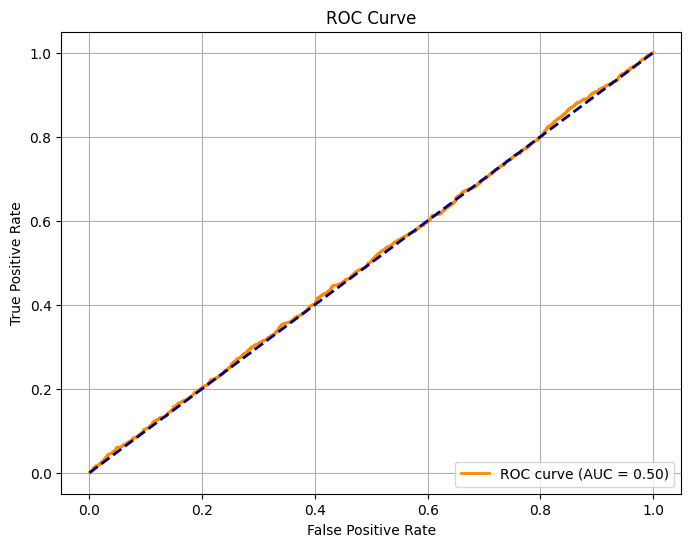

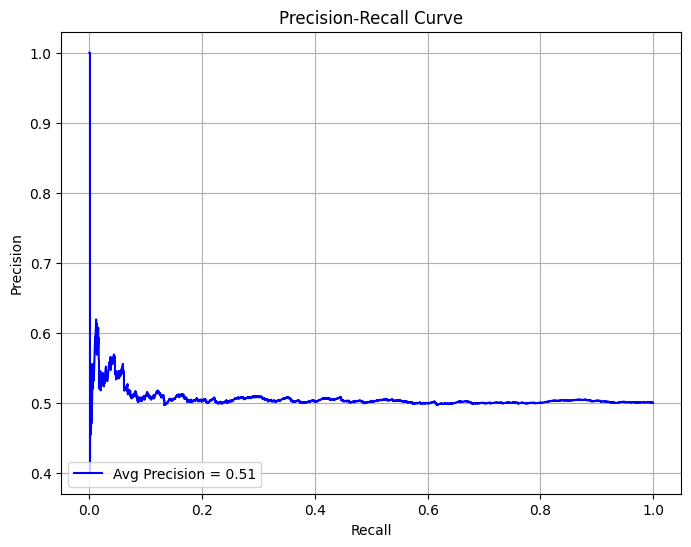

In [44]:
# Let's implemment in the neural networking part

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import pickle

# Let's implement the neural networking part


# Validate input shapes
assert len(X_train.shape) == 2, "X_train should be 2D"
assert len(y_train.shape) == 1 or y_train.shape[1] == 1, "y_train should be 1D or a column vector"

# Build the neural network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model architecture
print(model.summary())

# Train the model
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stop], verbose=1)

# Predict on test set
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Sensitivity (Recall for class 1)
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Sensitivity:", sensitivity)

# Specificity
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
print("Specificity:", specificity)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Save the model
model.save("neural_network_model.h5")





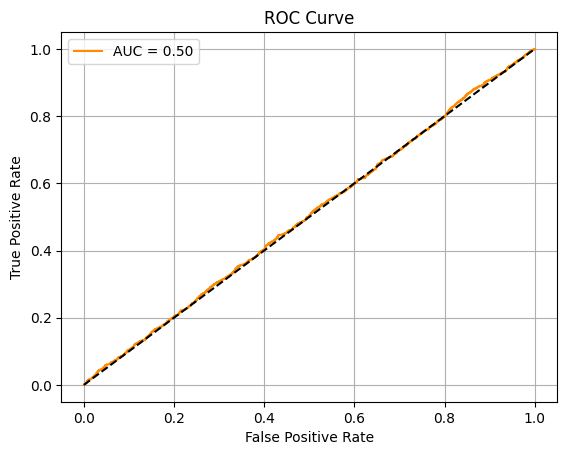

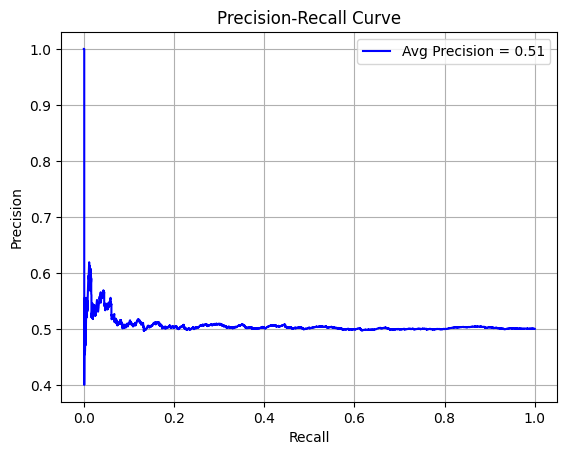

In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [46]:
model.save("neural_net_model.h5")


Let's Add the Deep Learning Method thoroally implemented !


Input the Microbeed and Non-microbleed roi to the relu model. This is for Deep-learning Purpose


In [47]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois


# Load the Excel file containing microbleed coordinates
excel_file = 'rcmb_coordinate_yes.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'rCMB_only'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10 # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        #print(f"{nifti_filename}: Extracted {len(microbleed_rois)} ROIs")
        
        X.append(microbleed_rois)

microbleed1_rois = X
print(len(microbleed1_rois))

57


In [48]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import scipy.ndimage
import nibabel as nib
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import radon
import matplotlib.pyplot as plt

Y = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois


# Load the Excel file containing microbleed coordinates
excel_file = 'rcmb_coordinate_non2.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'rCMB_only'  # Replace 'path_to_rCMB_folder' with your folder path
combined_features_list = []
# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        microbleed_coordinates = []
        for i in range(1, len(row), 3):
                try:
                    if pd.notnull(row.iloc[i]) and pd.notnull(row.iloc[i+1]) and pd.notnull(row.iloc[i+2]):
                        x = int(row.iloc[i])
                        y = int(row.iloc[i+1])
                        z = int(row.iloc[i+2])
                        microbleed_coordinates.append((x, y, z))
                except (ValueError, TypeError):
                    pass
            # Define the size of the ROI around each microbleed
        roi_size = 10 # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        #print(f"{nifti_filename}: Extracted {len(microbleed_rois)} ROIs")
        
        Y.append(microbleed_rois)

non_microbleed1_rois = Y
print(len(non_microbleed1_rois))

57


In [49]:
microbleed1_rois
non_microbleed1_rois

print(f"Microbleed ROIs: {len(microbleed1_rois)}")
print(f"Non-microbleed ROIs: {len(non_microbleed1_rois)}")



Microbleed ROIs: 57
Non-microbleed ROIs: 57


In [50]:
print(f"Type of non_microbleed1_rois[0]: {type(non_microbleed1_rois[0])}")
for i, roi in enumerate(non_microbleed1_rois[0]):
    print(f"Shape of channel {i}: {np.array(roi).shape}")


Type of non_microbleed1_rois[0]: <class 'list'>
Shape of channel 0: (10, 10, 10)
Shape of channel 1: (10, 10, 10)
Shape of channel 2: (10, 10, 5)


In [51]:
for i, roi in enumerate(non_microbleed1_rois[1]):
    print(f"Shape of channel {i} in second non-microbleed ROI: {np.array(roi).shape}")


Shape of channel 0 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 1 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 2 in second non-microbleed ROI: (10, 10, 10)


In [52]:
def is_valid_roi(roi, expected_shape=(10, 10, 10)):
    return all(np.array(r).shape == expected_shape for r in roi)

valid_microbleed_rois = [roi for roi in microbleed1_rois if is_valid_roi(roi)]
valid_non_microbleed_rois = [roi for roi in non_microbleed1_rois if is_valid_roi(roi)]

print(f"Valid microbleed ROIs: {len(valid_microbleed_rois)}")
print(f"Valid non-microbleed ROIs: {len(valid_non_microbleed_rois)}")


Valid microbleed ROIs: 57
Valid non-microbleed ROIs: 44


In [53]:
for i, roi in enumerate(valid_non_microbleed_rois[1]):
    print(f"Shape of channel {i} in second non-microbleed ROI: {np.array(roi).shape}")

for i, roi in enumerate(valid_microbleed_rois[1]):
    print(f"Shape of channel {i} in second non-microbleed ROI: {np.array(roi).shape}")


Shape of channel 0 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 1 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 2 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 0 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 1 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 2 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 3 in second non-microbleed ROI: (10, 10, 10)
Shape of channel 4 in second non-microbleed ROI: (10, 10, 10)


In [54]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt

# ------------------ MODEL ------------------

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock3D, self).__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        print("Input shape to model:", x.shape)
        ...

        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class CMBResNet3D(nn.Module):
    def __init__(self):
        super(CMBResNet3D, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=3, padding=1),  # Changed from 1 to 3
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True)
        )

        self.avg_pool = nn.AvgPool3d(kernel_size=2)
        self.layer1 = ResidualBlock3D(16, 16)
        self.layer2 = ResidualBlock3D(16, 16, downsample=True)
        self.layer3 = ResidualBlock3D(16, 32)
        self.layer4 = ResidualBlock3D(32, 32, downsample=True)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.avg_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------ DATASET ------------------

class MicrobleedVolumeDataset(Dataset):
    def __init__(self, volumes, labels, transform=None):
        self.volumes = volumes
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.volumes)

    def __getitem__(self, idx):
        volume = self.volumes[idx]
        label = self.labels[idx]
        volume = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)  # shape: (1, D, H, W)
        label = torch.tensor(label, dtype=torch.long)
        return volume, label

# ------------------ SHAPE UTILITY ------------------

import numpy as np

def ensure_roi_shape(rois, target_shape=(16, 16, 16), target_channels=3):
    fixed_rois = []
    for roi in rois:
        roi = np.array(roi)
        c, d, h, w = roi.shape  # (channels, depth, height, width)
        
        # Handle the case where the ROI has more channels than the target
        if c > target_channels:
            # Option 1: Crop to target channels
            roi = roi[:target_channels, :, :, :]
        elif c < target_channels:
            # Option 2: Pad with zeros to target channels
            padded_roi = np.zeros((target_channels, d, h, w))  # Create a zero-padded ROI
            padded_roi[:c, :, :, :] = roi  # Copy the original channels into the padded array
            roi = padded_roi
        
        # Resize the volume to match the target shape (D, H, W)
        if roi.shape[1:] != target_shape:
            resized_roi = np.zeros((target_channels, *target_shape))  # (channels, D, H, W)
            slices = tuple(slice(0, min(dim, target)) for dim, target in zip(roi.shape[1:], target_shape))
            resized_roi[:, slices[0], slices[1], slices[2]] = roi[:, slices[0], slices[1], slices[2]]
            fixed_rois.append(resized_roi)
        else:
            fixed_rois.append(roi)
    return fixed_rois



valid_non_microbleed_rois , valid_microbleed_rois
# Ensure all ROIs have the same number of channels
target_channels = 3  # You can set this to 2 or whichever channel size you want to standardize to
microbleed_rois1 = ensure_roi_shape(valid_microbleed_rois, target_channels=target_channels)
nonmicrobleed_rois1 = ensure_roi_shape(valid_non_microbleed_rois, target_channels=target_channels)

# Stack the ROIs
microbleed_rois2 = np.stack(microbleed_rois1)  # (N, C, D, H, W)
nonmicrobleed_rois2 = np.stack(nonmicrobleed_rois1)

print(f"Shape of microbleed_rois: {microbleed_rois2.shape}")
print(f"Shape of nonmicrobleed_rois: {nonmicrobleed_rois2.shape}")


# ------------------ MAIN EXECUTION ------------------

def main():
    # Example: Assuming you've loaded these already
    

    # Fix ROI shape
    microbleed_rois = ensure_roi_shape(valid_microbleed_rois)
    nonmicrobleed_rois = ensure_roi_shape(valid_non_microbleed_rois)

    # Convert to arrays
    microbleed_rois = np.stack(microbleed_rois)  # (N, D, H, W)
    nonmicrobleed_rois = np.stack(nonmicrobleed_rois)

    print(f"Shape of microbleed_rois: {microbleed_rois.shape}")
    print(f"Shape of nonmicrobleed_rois: {nonmicrobleed_rois.shape}")

    # Labels
    microbleed_labels = np.ones(len(microbleed_rois), dtype=np.int64)
    nonmicrobleed_labels = np.zeros(len(nonmicrobleed_rois), dtype=np.int64)

    # Combine
    X = np.concatenate((microbleed_rois, nonmicrobleed_rois), axis=0)
    y = np.concatenate((microbleed_labels, nonmicrobleed_labels), axis=0)

    print(f"Total ROIs: {len(X)}")
    print(f"Class distribution: {np.bincount(y)}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Dataset + Dataloader
    train_dataset = MicrobleedVolumeDataset(X_train, y_train)
    test_dataset = MicrobleedVolumeDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = CMBResNet3D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    train_losses = []
    test_accuracies = []
    num_epochs = 20

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training Loss")

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title("Test Accuracy")

    plt.tight_layout()
    plt.show()
    torch.save(model.state_dict(), "cmb_resnet3d.pth")
    print("Model saved as 'cmb_resnet3d.pth'")

if __name__ == "__main__":
    main()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape of microbleed_rois: (57, 3, 16, 16, 16)
Shape of nonmicrobleed_rois: (44, 3, 16, 16, 16)
Shape of microbleed_rois: (57, 3, 16, 16, 16)
Shape of nonmicrobleed_rois: (44, 3, 16, 16, 16)
Total ROIs: 101
Class distribution: [44 57]
Using device: cuda


RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [4, 1, 3, 16, 16, 16]

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt

# ResidualBlock3D and CMBResNet3D (unchanged)
class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock3D, self).__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class CMBResNet3D(nn.Module):
    def __init__(self):
        super(CMBResNet3D, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True)
        )
        self.avg_pool = nn.AvgPool3d(kernel_size=2)
        self.layer1 = ResidualBlock3D(16, 16)
        self.layer2 = ResidualBlock3D(16, 16, downsample=True)
        self.layer3 = ResidualBlock3D(16, 32)
        self.layer4 = ResidualBlock3D(32, 32, downsample=True)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.avg_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# MicrobleedVolumeDataset (unchanged)
class MicrobleedVolumeDataset(Dataset):
    def __init__(self, volumes, labels, transform=None):
        self.volumes = volumes
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.volumes)

    def __getitem__(self, idx):
        volume = self.volumes[idx]
        label = self.labels[idx]
        volume = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)
        # Ensure label is a Long tensor
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            volume = self.transform(volume)
        return volume, label

# load_volumes_from_slices (unchanged)
def load_volumes_from_slices(image_dir, slice_depth=32, resize_shape=(32, 32)):
    volumes = []
    slices = []
    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = cv2.resize(image, resize_shape)
                image = image / 255.0
                slices.append(image)
                if len(slices) == slice_depth:
                    volume = np.stack(slices, axis=0)
                    volumes.append(volume)
                    slices = []
            else:
                print(f"Error loading image: {image_path}. Skipping...")
    
    if slices:
        while len(slices) < slice_depth:
            slices.append(np.zeros(resize_shape))
        volume = np.stack(slices, axis=0)
        volumes.append(volume)
        print(f"Padded {slice_depth - len(slices) + len(slices)} slices in {image_dir} to form a full volume.")
    
    return np.array(volumes)

# Updated: Ensure labels are Long type
def load_and_group_labels(label_file, num_volumes, slice_depth=32):
    with open(label_file, 'r') as file:
        labels = [int(label.strip()) for label in file.readlines()]
    
    # Group labels by volume (majority vote)
    grouped_labels = []
    for i in range(0, len(labels), slice_depth):
        group = labels[i:i + slice_depth]
        if group:
            grouped_labels.append(1 if sum(group) > len(group) / 2 else 0)
    
    # Match number of volumes
    if len(grouped_labels) < num_volumes:
        grouped_labels.extend([0] * (num_volumes - len(grouped_labels)))
        print(f"Padded labels to match {num_volumes} volumes.")
    elif len(grouped_labels) > num_volumes:
        grouped_labels = grouped_labels[:num_volumes]
        print(f"Truncated labels to match {num_volumes} volumes.")
    
    # Return as Long tensor
    return torch.tensor(grouped_labels, dtype=torch.long).numpy()


def ensure_roi_shape(rois, target_shape=(16, 16, 16)):
    """
    Ensure that all ROIs have the same shape by padding or cropping.
    """
    fixed_rois = []
    for roi in rois:
        roi = np.array(roi)  # Ensure it's a NumPy array
        if roi.shape != target_shape:
            # Pad or crop to target shape
            fixed_roi = np.zeros(target_shape)
            slices = tuple(slice(0, min(dim, target)) for dim, target in zip(roi.shape, target_shape))
            fixed_roi[slices] = roi[slices]
            fixed_rois.append(fixed_roi)
        else:
            fixed_rois.append(roi)
    return fixed_rois


microbleed1_rois
non_microbleed1_rois

# Fix shape mismatch and convert to proper array
microbleed_rois = ensure_roi_shape(microbleed1_rois)
non1_microbleed_rois = ensure_roi_shape(non_microbleed1_rois)

# Convert to NumPy arrays with consistent shape
microbleed_rois = np.stack(microbleed_rois)  # shape: (N1, D, H, W)
non1_microbleed_rois = np.stack(non1_microbleed_rois)  # shape: (N2, D, H, W)

print(f"Shape of microbleed_rois: {microbleed_rois.shape}")
print(f"Shape of non1_microbleed_rois: {non1_microbleed_rois.shape}")

# Labels
microbleed_labels = np.ones(len(microbleed_rois), dtype=np.int64)
nonmicrobleed_labels = np.zeros(len(non1_microbleed_rois), dtype=np.int64)

# Combine ROIs and labels
X = np.concatenate((microbleed_rois, non1_microbleed_rois), axis=0)
y = np.concatenate((microbleed_labels, nonmicrobleed_labels), axis=0)

print(f"Total ROIs: {len(X)}")
print(f"Class distribution: {np.bincount(y)}")  # assumes labels are 0 and 1




from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)



# Step 9: Data Augmentation (unchanged)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
train_dataset = MicrobleedVolumeDataset(X_train, y_train)
test_dataset = MicrobleedVolumeDataset(X_test, y_test)


# Step 11: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

# Step 12: Training Function (unchanged)
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

# Step 13: Main Execution
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = CMBResNet3D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    train_losses, test_accuracies = train_model(
        model, train_loader, test_loader, criterion, optimizer, num_epochs, device
    )

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    torch.save(model.state_dict(), 'cmb_resnet3d.pth')
    print("Model saved as 'cmb_resnet3d.pth'")

if __name__ == "__main__":
    main()

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: could not broadcast input array from shape (2,10,10,10) into shape (2,10,10)

Prediction in new dataset 

In [ ]:
import pickle

model_path = 'rf_classifier_model.pkl'  # Change the path if it's different
with open(model_path, 'rb') as model_file:
    trained_model = pickle.load(model_file)

In [ ]:
import pickle

model_path = 'rf_classifier_model.pkl'  # Change the path if it's different
with open(model_path, 'rb') as model_file:
    trained_model = pickle.load(model_file)

In [ ]:
# Assuming you have the coordinate (129, 167, 55)
test_coordinate = (120, 150, 70)
roi_size = 10  # Same as the one used during feature extraction

swi_img = nib.load('305_T1_MRI_SWI_BFC_50mm_HM.nii.gz')  # Provide the correct path
swi_data = swi_img.get_fdata()

# Extract the ROI around the given coordinate
test_roi = extract_roi(swi_data, [test_coordinate], roi_size)[0]

# Compute Hessian matrix and eigenvalues for the ROI
eigenvalues_test_roi, _ = compute_hessian_eigenvalues(test_roi)

# Compute Radon features for the ROI
angles = np.arange(0, 180, 15)
radon_features_test_roi = compute_radon_features([test_roi], angles)
# Compute Radon shape features for the ROI
fmean_test_roi, fstd_test_roi = compute_radon_shape_features(radon_features_test_roi)
# Combine the features
flattened_radon_values_test_roi = np.concatenate((fmean_test_roi.flatten(), fstd_test_roi.flatten()))
combined_features_test_roi = np.concatenate((flattened_radon_values_test_roi, np.array(compute_hessian_shape_features(eigenvalues_test_roi))))

# Reshape the features to match the input format expected by the model
features_for_prediction = combined_features_test_roi.reshape(1, -1)

In [ ]:
prediction = trained_model.predict(features_for_prediction)
print(f"Prediction for coordinate {test_coordinate}: {prediction}")

Prediction for coordinate (120, 150, 70): [0.]
